In [ ]:
# ! pip install yfinance pandas numpy scipy scikit-learn matplotlib networkx seaborn nbformat

# 1. Asset pre-selection


Data Coolection and Asset Pre-selection
> **Goal** - A diverse-, low-correlated and economically meaningful set of assets.



### 1. Overview of Pre-Selection Principles

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import networkx as nx
import datetime as dt
import os
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Data Preprocessing and Monthly Returns

| Category                    | Count | Notes                                      |
| --------------------------- | ----- | ------------------------------------------ |
| U.S. Large Cap Equities     | 35    | Blue-chip stocks across all GICS sectors   |
| Sector & Thematic ETFs      | 25    | U.S.-listed ETFs (broad, sector, thematic) |
| REITs                       | 10    | USD REITs                                  |
| Bonds & Fixed Income ETFs   | 10    | U.S. Treasury & corporate bond ETFs        |
| Commodities ETFs            | 10    | USD-quoted commodity ETFs                  |
| Defensive / Dividend Stocks | 10    | Stable dividend payers (defensives)        |


In [ ]:
us_large_cap = [
    "AAPL", "MSFT", "GOOG", "AMZN", "META", "NVDA", "TSLA", "BRK-B", "JPM", "V",
    "PG", "HD", "UNH", "MA", "PFE", "KO", "PEP", "DIS", "XOM", "BAC",
    "NFLX", "CSCO", "INTC", "WMT", "CVX", "ABBV", "NKE", "MRK", "MCD", "COST",
    "CRM", "AMD", "AVGO", "TMO", "LLY"
]

sector_etfs = [
    "SPY", "QQQ", "DIA", "IWM", "XLK", "XLF", "XLE", "XLV", "XLY", "XLP",
    "XLI", "XLRE", "XLC", "ARKK", "SMH", "SOXX", "IYT", "XAR", "XHB", "VNQ",
    "VTI", "VOO", "VT", "VEA", "IJR"
]

reits = [
    "AMT", "PLD", "CCI", "SPG", "O", "EQIX", "WELL", "PSA", "VTR", "DLR"
]

bonds = [
    "TLT", "IEF", "LQD", "HYG", "BND", "AGG", "SHY", "EMB", "TIP", "BIL"
]

commodities = [
    "GLD", "SLV", "USO", "DBA", "CPER", "URA", "UNG", "CORN", "WEAT", "PALL"
]

dividend_defensive = [
    "KO", "PEP", "JNJ", "PG", "DUK", "SO", "CL", "WMT", "COST", "TGT"
]

ticker_list = (
    us_large_cap +
    sector_etfs +
    reits +
    bonds +
    commodities +
    dividend_defensive
)

print("Total tickers:", len(ticker_list))


Total tickers: 100


In [ ]:
START_DATE = '2015-01-01'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d')
MIN_MONTHS_HISTORY = 60
MIN_AVG_DAILY_VOLUME = 100_000
FINAL_K = 30
OUT_FOLDER = "asset_preselection_outputs"
os.makedirs(OUT_FOLDER, exist_ok=True)


In [ ]:
def fetch_daily_data(tickers, start, end):
    raw = yf.download(tickers, start=start, end=end, progress=True, group_by='ticker', auto_adjust=False)
    if isinstance(raw.columns, pd.MultiIndex):
        adj = pd.DataFrame({t: raw[(t, 'Adj Close')] if (t, 'Adj Close') in raw.columns else raw[(t, 'Close')] for t in tickers})
        vol = pd.DataFrame({t: raw[(t, 'Volume')] if (t, 'Volume') in raw.columns else np.nan for t in tickers})
    else:
        adj = raw['Adj Close'].to_frame() if 'Adj Close' in raw else raw['Close'].to_frame()
        adj.columns = tickers
        vol = raw['Volume'].to_frame()
        vol.columns = tickers
    adj = adj.dropna(axis=1, how='all')
    vol = vol.reindex(adj.index).fillna(method='ffill')
    return adj, vol
adj_daily, volume_daily = fetch_daily_data(ticker_list, START_DATE, END_DATE)
print("Downloaded price columns:", adj_daily.columns.tolist())

[*********************100%***********************]  95 of 95 completed


Downloaded price columns: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'ABBV', 'NKE', 'MRK', 'MCD', 'COST', 'CRM', 'AMD', 'AVGO', 'TMO', 'LLY', 'SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLC', 'ARKK', 'SMH', 'SOXX', 'IYT', 'XAR', 'XHB', 'VNQ', 'VTI', 'VOO', 'VT', 'VEA', 'IJR', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'TIP', 'BIL', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA', 'UNG', 'CORN', 'WEAT', 'PALL', 'JNJ', 'DUK', 'SO', 'CL', 'TGT']


In [ ]:
# Computing monthly last price (month-end) and computing monthly returns
adj_monthly = adj_daily.resample('M').last().ffill()

def avg_daily_volume_over_period(volume_df, window_days=252):
    return volume_df.rolling(window=window_days, min_periods=1).mean().iloc[-1]

avg_vol = avg_daily_volume_over_period(volume_daily, window_days=252)
avg_vol = avg_vol.fillna(0)
meta = pd.DataFrame({
    'ticker': adj_monthly.columns,
    'first_date': adj_monthly.notna().idxmax(),
    'last_date': adj_monthly.notna().idxmin(),  # not perfect but we store for reference
    'avg_daily_volume': avg_vol.reindex(adj_monthly.columns).fillna(0).values
}).set_index('ticker')
print(meta.head())

       first_date  last_date  avg_daily_volume
ticker                                        
AAPL   2015-01-31 2015-01-31      5.370442e+07
MSFT   2015-01-31 2015-01-31      2.171225e+07
GOOG   2015-01-31 2015-01-31      2.253466e+07
AMZN   2015-01-31 2015-01-31      4.259872e+07
META   2015-01-31 2015-01-31      1.398836e+07


In [ ]:
# Chistory + liquidity filters
def history_filter(price_monthly_df, min_months=60):
    valid = price_monthly_df.notna().sum(axis=0) >= min_months
    return price_monthly_df.loc[:, valid]

# require at least MIN_MONTHS_HISTORY
adj_monthly_filtered = history_filter(adj_monthly, min_months=MIN_MONTHS_HISTORY)

# liquidity threshold
liquid_tickers = meta.loc[adj_monthly_filtered.columns]['avg_daily_volume'] >= MIN_AVG_DAILY_VOLUME
liquid_tickers = liquid_tickers[liquid_tickers].index.tolist()

# Final tickers after both filters
final_universe_tickers = [t for t in adj_monthly_filtered.columns if t in liquid_tickers]
adj_monthly_filtered = adj_monthly_filtered[final_universe_tickers]

print(f"Universe size after filters: {len(adj_monthly_filtered.columns)}")
print("Tickers:", list(adj_monthly_filtered.columns))

Universe size after filters: 94
Tickers: ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'V', 'PG', 'HD', 'UNH', 'MA', 'PFE', 'KO', 'PEP', 'DIS', 'XOM', 'BAC', 'NFLX', 'CSCO', 'INTC', 'WMT', 'CVX', 'ABBV', 'NKE', 'MRK', 'MCD', 'COST', 'CRM', 'AMD', 'AVGO', 'TMO', 'LLY', 'SPY', 'QQQ', 'DIA', 'IWM', 'XLK', 'XLF', 'XLE', 'XLV', 'XLY', 'XLP', 'XLI', 'XLRE', 'XLC', 'ARKK', 'SMH', 'SOXX', 'IYT', 'XAR', 'XHB', 'VNQ', 'VTI', 'VOO', 'VT', 'VEA', 'IJR', 'AMT', 'PLD', 'CCI', 'SPG', 'O', 'EQIX', 'WELL', 'PSA', 'VTR', 'DLR', 'TLT', 'IEF', 'LQD', 'HYG', 'BND', 'AGG', 'SHY', 'EMB', 'TIP', 'BIL', 'GLD', 'SLV', 'USO', 'DBA', 'CPER', 'URA', 'UNG', 'WEAT', 'PALL', 'JNJ', 'DUK', 'SO', 'CL', 'TGT']


In [ ]:
# monthly log returns (T x N)
returns = np.log(adj_monthly_filtered).diff().dropna()
returns.head()

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-31,0.027599,0.073021,0.087165,0.044664,-0.118645,0.033049,-0.140021,0.058375,0.103605,0.031876,...,-0.044257,0.023042,-0.038276,0.084134,-0.019955,0.088137,0.031615,0.048265,0.039803,0.058180
2018-08-31,0.182674,0.061088,0.000764,0.124308,0.018088,0.137075,0.011737,0.053383,-0.003224,0.073105,...,-0.068195,-0.034766,0.048769,-0.039682,0.049214,0.022884,0.006735,-0.091734,-0.008994,0.088977
2018-09-30,-0.008337,0.017998,-0.020501,-0.004836,-0.066281,0.001211,-0.130439,0.025496,-0.015302,0.021551,...,0.050156,0.045340,0.036084,-0.065038,0.090338,0.025509,-0.015131,-0.004120,0.008098,0.008082
2018-10-31,-0.030952,-0.068387,-0.102899,-0.225887,-0.080170,-0.287374,0.242171,-0.042115,-0.027461,-0.085069,...,-0.052551,-0.102776,0.072611,-0.017757,0.004592,0.013086,0.032097,0.032272,-0.110499,-0.053318
2018-11-30,-0.199912,0.041798,0.016268,0.056070,-0.076508,-0.253668,0.038272,0.061221,0.019709,0.029410,...,0.043409,0.043184,0.334866,-0.011466,0.084636,0.054529,0.080217,0.062614,0.064539,-0.156025


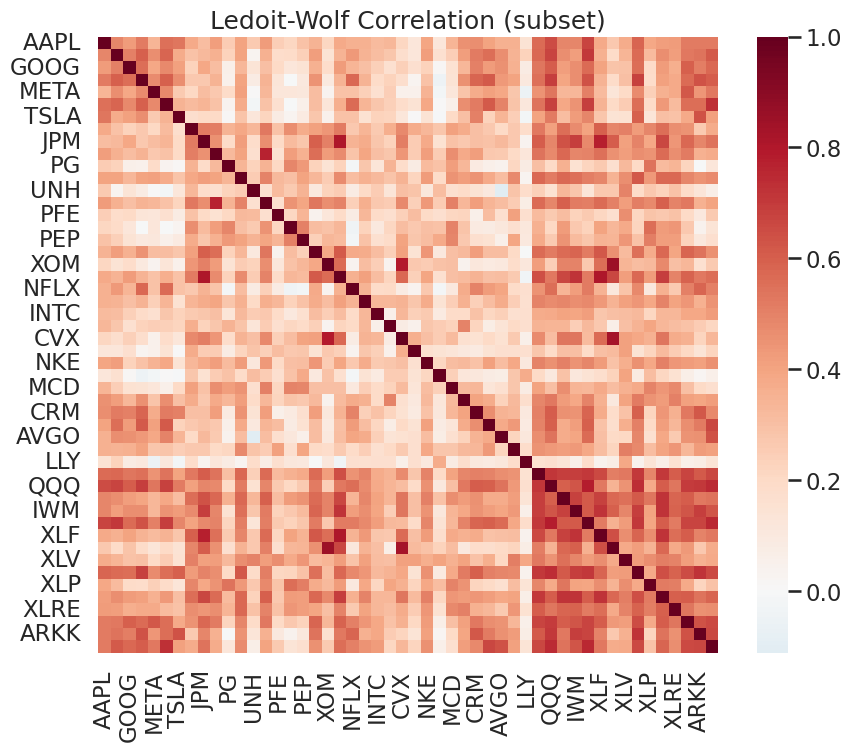

In [ ]:
# Ledoit-Wolf covariance estimator (stable covariance)
lw = LedoitWolf().fit(returns.values)
cov_lw = lw.covariance_
# converting covariance matrix to DataFrame with tickers index/columns
cov_lw_df = pd.DataFrame(cov_lw, index=returns.columns, columns=returns.columns)

# computing correlation matrix from cov
std = np.sqrt(np.diag(cov_lw))
corr_lw = cov_lw / np.outer(std, std)
corr_lw_df = pd.DataFrame(corr_lw, index=returns.columns, columns=returns.columns)

# quick heatmap check
plt.figure(figsize=(10,8))
sns.heatmap(corr_lw_df.iloc[:50, :50], cmap='RdBu_r', center=0)
plt.title('Ledoit-Wolf Correlation (subset)')
plt.show()

In [ ]:
corr_lw_df

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
AAPL,1.000000,0.491274,0.423203,0.519121,0.337233,0.549059,0.535811,0.380999,0.305751,0.417382,...,0.175620,0.193733,0.103310,-0.003327,-0.011232,0.308137,0.121940,0.174507,0.209337,0.398099
MSFT,0.491274,1.000000,0.505937,0.594785,0.466222,0.584836,0.373277,0.289483,0.324503,0.361220,...,0.178527,0.338296,0.071042,-0.081208,0.040314,0.237994,0.132343,0.189887,0.265600,0.313444
GOOG,0.423203,0.505937,1.000000,0.557313,0.386468,0.479761,0.411571,0.233297,0.384929,0.307100,...,0.303374,0.393031,0.004567,0.012770,0.110626,0.108306,0.145320,0.196520,0.082318,0.265660
AMZN,0.519121,0.594785,0.557313,1.000000,0.473242,0.594249,0.465673,0.271976,0.269946,0.348039,...,0.166600,0.388456,0.067744,0.019522,-0.001731,0.110092,0.027130,0.075558,0.154332,0.278033
META,0.337233,0.466222,0.386468,0.473242,1.000000,0.476730,0.260282,0.206178,0.311397,0.273479,...,0.247231,0.218902,0.036768,-0.156784,0.055260,0.139776,0.157768,0.249480,0.214075,0.293805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JNJ,0.308137,0.237994,0.108306,0.110092,0.139776,0.086799,0.108215,0.471597,0.333534,0.354557,...,0.152643,0.142911,0.094340,0.018131,0.087144,1.000000,0.342524,0.353116,0.305797,0.225825
DUK,0.121940,0.132343,0.145320,0.027130,0.157768,0.010955,0.020150,0.362057,0.256923,0.217499,...,0.203031,0.101963,0.079860,0.032199,0.165305,0.342524,1.000000,0.600000,0.339156,0.162814
SO,0.174507,0.189887,0.196520,0.075558,0.249480,-0.001980,-0.021372,0.331558,0.262275,0.255674,...,0.194162,0.133412,0.130645,0.122223,0.148698,0.353116,0.600000,1.000000,0.402605,0.133699
CL,0.209337,0.265600,0.082318,0.154332,0.214075,0.082577,-0.073755,0.355987,0.252369,0.364016,...,0.176126,0.041512,0.053438,-0.130542,-0.029245,0.305797,0.339156,0.402605,1.000000,0.148875


In [ ]:
# Spearman correlation (rank-based)
corr_spearman = returns.corr(method='spearman')

# distance correlation- function + pairwise matrix
def distance_covariance(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    a = np.abs(x[:, None] - x[None, :])
    b = np.abs(y[:, None] - y[None, :])
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    return np.sqrt(np.sum(A * B) / (n * n))

def distance_corr(x, y):
    dxy = distance_covariance(x, y)
    dxx = distance_covariance(x, x)
    dyy = distance_covariance(y, y)
    if dxx * dyy == 0:
        return 0.0
    return dxy / np.sqrt(dxx * dyy)

# pairwise distance correlation matrix
def pairwise_distance_corr(returns_df):
    cols = returns_df.columns.tolist()
    n = len(cols)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            dc = distance_corr(returns_df.iloc[:, i].values, returns_df.iloc[:, j].values)
            mat[i, j] = dc
            mat[j, i] = dc
    return pd.DataFrame(mat, index=cols, columns=cols)

dist_corr_df = pairwise_distance_corr(returns)
dist_corr_df.head()

,AAPL,MSFT,GOOG,AMZN,META,NVDA,TSLA,BRK-B,JPM,V,...,CPER,URA,UNG,WEAT,PALL,JNJ,DUK,SO,CL,TGT
AAPL,1.000000,0.593934,0.474066,0.550122,0.449565,0.567269,0.559222,0.418338,0.370521,0.475103,...,0.247418,0.247409,0.201492,0.126376,0.141874,0.381361,0.251087,0.270561,0.276469,0.411877
MSFT,0.593934,1.000000,0.584024,0.686692,0.558081,0.634925,0.402911,0.378848,0.411090,0.468839,...,0.268625,0.357493,0.202452,0.164765,0.167557,0.320276,0.207294,0.243527,0.332135,0.394677
GOOG,0.474066,0.584024,1.000000,0.590099,0.452588,0.495430,0.385597,0.324124,0.450546,0.385201,...,0.374587,0.461488,0.172139,0.174041,0.190306,0.238949,0.279772,0.268642,0.187992,0.339057
AMZN,0.550122,0.686692,0.590099,1.000000,0.551526,0.581358,0.477002,0.300843,0.340594,0.419768,...,0.214933,0.409067,0.206050,0.217645,0.164152,0.199168,0.145317,0.177219,0.211005,0.337915
META,0.449565,0.558081,0.452588,0.551526,1.000000,0.558986,0.299717,0.309053,0.463645,0.390467,...,0.318746,0.311668,0.172188,0.228978,0.143893,0.237119,0.205224,0.270739,0.270708,0.371947


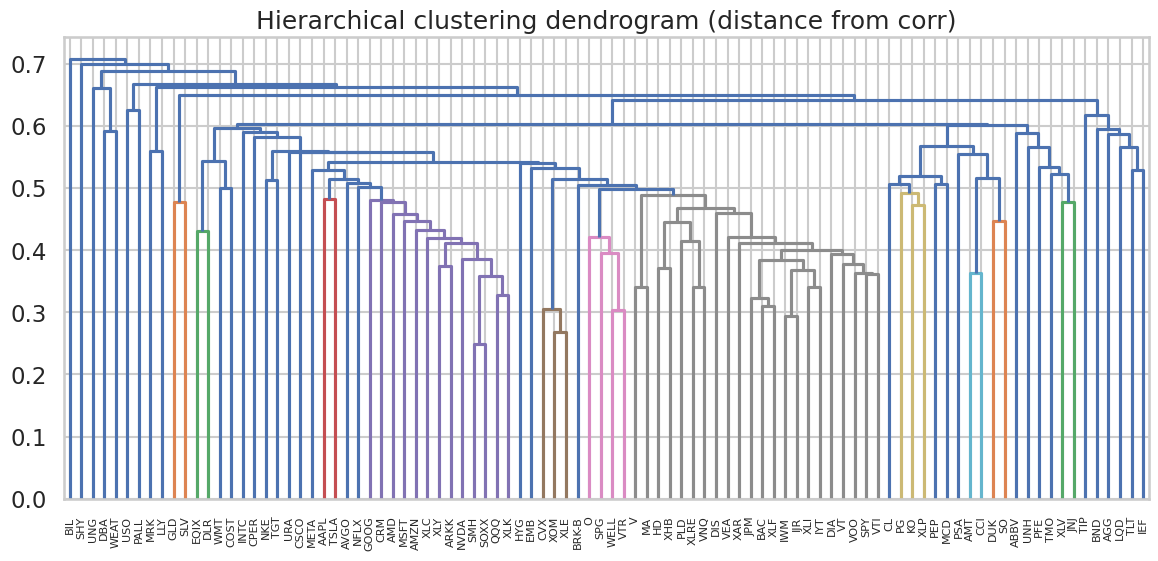

In [ ]:
# hierarchical clustering on Pearson (Ledoit-Wolf) correlation
# converting correlations to distance metric for clustering
corr = corr_lw_df.copy()
corr = corr.clip(-0.9999, 0.9999)  # safety for sqrt
dist_matrix = np.sqrt((1 - corr) / 2)  # standard distance transform

# convert to condensed distance vector (required by linkage)
condensed = squareform(dist_matrix.values, checks=False)
Z = linkage(condensed, method='average')  # 'average' is robust (Ward also works on Euclidean)

# plot dendrogram for visual inspection (useful for smaller N)
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=returns.columns.tolist(), leaf_rotation=90, leaf_font_size=8)
plt.title('Hierarchical clustering dendrogram (distance from corr)')
plt.show()

### Category 1 Assets/Tickers

In [ ]:
# greedy selection which iteratively picks the asset with minimal average corr to already selected set
def greedy_min_avg_corr(corr_df, k=30):
    names = corr_df.columns.tolist()
    selected = []
    avg_corr = corr_df.mean(axis=1)
    first = avg_corr.idxmin()
    selected.append(first)
    while len(selected) < k:
        candidates = [n for n in names if n not in selected]
        # computing average correlation to the selected set for each candidate
        scores = {c: corr_df.loc[c, selected].mean() for c in candidates}
        # picking candidate with minimal average correlation to selected
        next_one = min(scores, key=scores.get)
        selected.append(next_one)
    return selected

k = min(FINAL_K, len(returns.columns))
greedy_selected = greedy_min_avg_corr(corr_lw_df, k=k)
print("Greedy selection count:", len(greedy_selected))
print(greedy_selected)

Greedy selection count: 30
['WEAT', 'CRM', 'BIL', 'SHY', 'PALL', 'LLY', 'UNG', 'GLD', 'USO', 'IEF', 'PFE', 'AGG', 'PG', 'AVGO', 'DBA', 'BND', 'XOM', 'TLT', 'UNH', 'TSLA', 'MRK', 'DLR', 'ABBV', 'TIP', 'NFLX', 'META', 'CL', 'WMT', 'URA', 'SO']


### Category 2 Assets/Tickers

In [ ]:
# generating cluster labels and pick representative(s)
n_clusters = min(FINAL_K, max(2, len(returns.columns)//2))
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({'ticker': returns.columns, 'cluster': clusters}).set_index('ticker')

# helper to pick representative per cluster: lowest mean intra-cluster correlation, tiebreak by liquidity
def pick_cluster_representatives(corr_df, meta_df, per_cluster=1):
    reps = []
    for c in sorted(cluster_df['cluster'].unique()):
        members = cluster_df[cluster_df['cluster'] == c].index.tolist()
        sub_corr = corr_df.loc[members, members]
        mean_intra = sub_corr.mean(axis=1)
        ranked = mean_intra.sort_values().index.tolist()  # low mean_intra = less correlated to own cluster
        # tiebreak by liquidity if meta available
        if per_cluster == 1:
            reps.append(ranked[0])
        else:
            picks = ranked[:min(per_cluster, len(ranked))]
            reps.extend(picks)
    return reps

cluster_reps = pick_cluster_representatives(corr_lw_df, meta, per_cluster=1)
print("Cluster reps count:", len(cluster_reps))
print(cluster_reps)

Cluster reps count: 30
['DBA', 'WEAT', 'UNG', 'USO', 'PALL', 'MRK', 'LLY', 'GLD', 'DLR', 'WMT', 'NKE', 'TSLA', 'HYG', 'CSCO', 'URA', 'CPER', 'INTC', 'CL', 'SO', 'PSA', 'PFE', 'UNH', 'ABBV', 'IEF', 'LQD', 'AGG', 'BND', 'TIP', 'SHY', 'BIL']


### Correlation for the Union of Category 1 and 2 Assets

> The correlation of All Assets that are in Category 1, 2 or both

In [ ]:
# Heatmap
selected_union = list(set(cluster_reps) | set(greedy_selected))
subset = corr_lw_df.loc[selected_union, selected_union].copy()
subset

,WEAT,CL,GLD,CSCO,TSLA,LQD,BIL,BND,SO,URA,...,CPER,TLT,PSA,UNH,MRK,META,XOM,TIP,NKE,HYG
WEAT,1.000000,-0.130542,0.038494,-0.111661,0.006789,-0.060594,-0.011364,-0.053441,0.122223,0.139318,...,0.137586,-0.033847,0.109823,0.062424,-0.007486,-0.156784,-0.044051,-0.009440,0.073548,-0.017912
CL,-0.130542,1.000000,0.111571,0.256496,-0.073755,0.203913,0.000158,0.122675,0.402605,0.041512,...,0.176126,0.115076,0.269205,0.228777,0.243841,0.214075,0.207268,0.149817,0.282664,0.209106
GLD,0.038494,0.111571,1.000000,0.030292,0.071145,0.208898,0.008778,0.164759,0.221740,0.148239,...,0.236071,0.235982,0.104651,0.125838,-0.014446,0.101822,-0.087791,0.165977,0.006812,0.125499
CSCO,-0.111661,0.256496,0.030292,1.000000,0.149524,0.193737,0.001621,0.097470,0.211974,0.315733,...,0.261294,0.032063,0.236068,0.199897,0.147220,0.243773,0.306008,0.146361,0.373532,0.299030
TSLA,0.006789,-0.073755,0.071145,0.149524,1.000000,0.174059,-0.007438,0.091649,-0.021372,0.292390,...,0.169943,0.089687,0.190065,0.124629,-0.010175,0.260282,0.050210,0.121169,0.147221,0.213734
LQD,-0.060594,0.203913,0.208898,0.193737,0.174059,1.000000,0.002994,0.315853,0.227482,0.191926,...,0.209779,0.420169,0.254087,0.092241,0.039154,0.271395,0.115547,0.273406,0.310420,0.342767
BIL,-0.011364,0.000158,0.008778,0.001621,-0.007438,0.002994,1.000000,0.003600,0.000306,-0.002089,...,-0.003204,0.003752,-0.004995,-0.010267,-0.004623,0.012747,-0.008279,-0.000543,-0.006451,0.001882
BND,-0.053441,0.122675,0.164759,0.097470,0.091649,0.315853,0.003600,1.000000,0.132877,0.087188,...,0.100352,0.356979,0.187895,0.054611,0.003967,0.163142,0.008644,0.206037,0.184197,0.199587
SO,0.122223,0.402605,0.221740,0.211974,-0.021372,0.227482,0.000306,0.132877,1.000000,0.133412,...,0.194162,0.110540,0.293116,0.210749,0.084307,0.249480,0.211384,0.158331,0.252023,0.254584
URA,0.139318,0.041512,0.148239,0.315733,0.292390,0.191926,-0.002089,0.087188,0.133412,1.000000,...,0.375546,0.003836,0.141497,0.143089,0.031886,0.218902,0.386790,0.136206,0.306788,0.292846


In [ ]:
corr = subset.copy()
np.fill_diagonal(corr.values, np.nan)
corr_unstacked = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).unstack()
corr_unstacked = corr_unstacked.dropna()
max_corr_pair = corr_unstacked.idxmax()
min_corr_pair = corr_unstacked.idxmin()
max_corr_value = corr_unstacked.max()
min_corr_value = corr_unstacked.min()
print(f"🔹 Highest correlation: {max_corr_value:.4f} between {max_corr_pair[0]} and {max_corr_pair[1]}")
print(f"🔹 Lowest  correlation: {min_corr_value:.4f} between {min_corr_pair[0]} and {min_corr_pair[1]}")

🔹 Highest correlation: 0.5027 between CRM and TSLA
🔹 Lowest  correlation: -0.2399 between TLT and USO


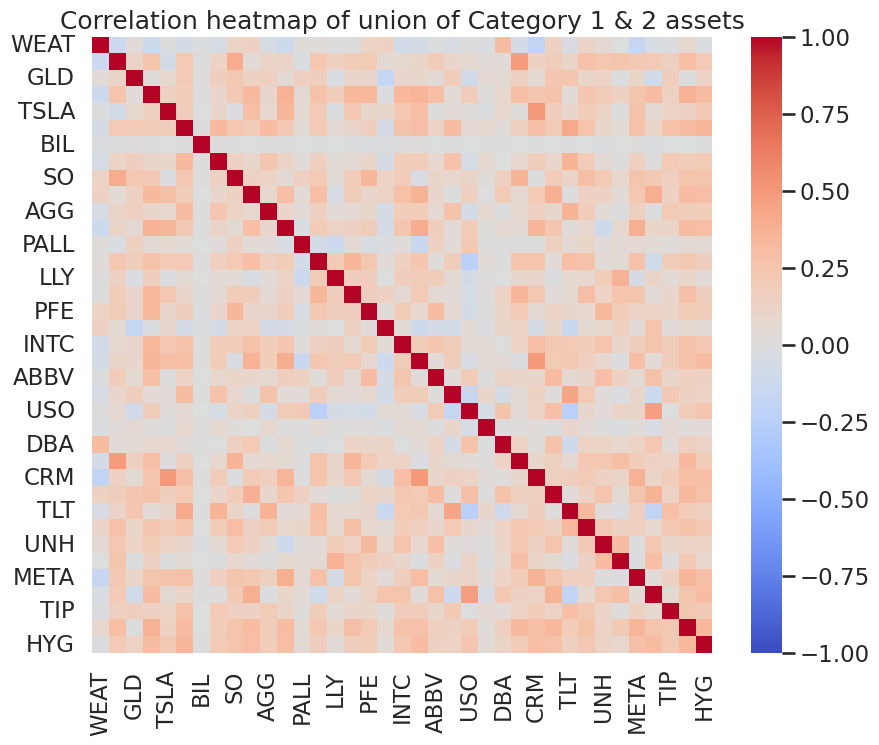

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=False)
plt.title('Correlation heatmap of union of Category 1 & 2 assets')
plt.show()

### Conditional correlations

In [ ]:
# PARAMETERS
market_ticker = 'SPY' # Benchmark Index
quantile_p = 0.10
n_boot = 2000
random_state = 42

# Sanity check inputs exist
for name in ['returns', 'corr_lw_df', 'greedy_selected', 'cluster_reps']:
    if name not in globals():
        raise NameError(f"Required variable '{name}' is not defined in the environment.")

# Ensure returns index is datetime-like (for resampling / selection safety)
returns.index = pd.to_datetime(returns.index)

# Helper utilities -
def upper_triangle_values_mean(corr_df):
    """Return mean of unique off-diagonal correlation values (upper triangle k=1)."""
    if corr_df.shape[0] < 2:
        return np.nan
    mat = corr_df.values
    iu = np.triu_indices_from(mat, k=1)
    vals = mat[iu]
    return float(np.nanmean(vals))

def bootstrap_avg_corr(returns_sub, months_idx, n_boot=1000, rng=None):
    """
    Bootstrap average off-diagonal correlation by resampling months (with replacement).
    returns_sub : DataFrame of returns (columns = tickers)
    months_idx    : sequence of timestamps (index values) to sample from
    """
    if rng is None:
        rng = np.random.default_rng(random_state)
    months = list(months_idx)
    if len(months) == 0:
        return np.array([]), (np.nan, np.nan)
    res = []
    pbar = None
    for _ in range(n_boot):
        samp_months = rng.choice(months, size=len(months), replace=True)
        try:
            R = returns_sub.loc[samp_months].dropna(axis=1, how='all')
        except Exception:
            # if indices don't align exactly, reindex
            R = returns_sub.reindex(samp_months).dropna(axis=1, how='all')
        if R.shape[1] < 2:
            res.append(np.nan)
            continue
        corr = R.corr()
        res.append(upper_triangle_values_mean(corr))
    arr = np.array(res, dtype=float)
    lower, upper = np.nanpercentile(arr, [2.5, 97.5])
    return arr, (lower, upper)

# Identifying crisis months (bottom decile of market returns)
if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

market_returns = returns[market_ticker].dropna()
threshold = market_returns.quantile(quantile_p)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)
print(f"Number of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Preparing Category lists and check presence in returns/corr matrices
cat1 = [t for t in greedy_selected if t in returns.columns]      # Category 1 (greedy)
cat2 = [t for t in cluster_reps if t in returns.columns]         # Category 2 (clusters)

missing_cat1 = sorted(set(greedy_selected) - set(cat1))
missing_cat2 = sorted(set(cluster_reps) - set(cat2))
if missing_cat1:
    print(f"Warning: {len(missing_cat1)} greedy_selected tickers missing from returns and will be ignored: {missing_cat1}")
if missing_cat2:
    print(f"Warning: {len(missing_cat2)} cluster_reps tickers missing from returns and will be ignored: {missing_cat2}")

# --- Utility to compute summary for a given list of tickers ---
def compute_category_summary(tickers, label):
    out = {'label': label, 'n_assets': len(tickers)}
    if len(tickers) < 2:
        out.update({
            'avg_full_offdiag': np.nan,
            'avg_crisis_offdiag': np.nan,
            'delta_crisis_minus_full': np.nan,
            'full_ci_lower': np.nan, 'full_ci_upper': np.nan,
            'crisis_ci_lower': np.nan, 'crisis_ci_upper': np.nan
        })
        return out

    # Full-sample correlation (Ledoit-Wolf) -- use corr_lw_df if it contains tickers
    if not set(tickers).issubset(set(corr_lw_df.index)):
        # If corr_lw_df doesn't include some tickers, fallback to sample corr computed on full returns
        corr_full = returns[tickers].dropna(axis=1, how='all').corr()
    else:
        corr_full = corr_lw_df.loc[tickers, tickers]

    avg_full = upper_triangle_values_mean(corr_full)

    # Crisis correlation (sample on crisis months)
    R_crisis = returns.loc[crisis_idx, tickers].dropna(axis=1, how='all')
    if R_crisis.shape[1] < 2 or R_crisis.shape[0] == 0:
        avg_crisis = np.nan
    else:
        corr_crisis = R_crisis.corr()
        avg_crisis = upper_triangle_values_mean(corr_crisis)

    # Bootstrapped CIs (months-level bootstrap)
    # Full-sample bootstrap: resampling from full sample months
    full_arr, (full_lo, full_hi) = bootstrap_avg_corr(returns[tickers], returns.index, n_boot=n_boot)
    crisis_arr, (crisis_lo, crisis_hi) = bootstrap_avg_corr(returns[tickers], crisis_idx, n_boot=n_boot)

    out.update({
        'avg_full_offdiag': avg_full,
        'avg_crisis_offdiag': avg_crisis,
        'delta_crisis_minus_full': (avg_crisis - avg_full) if (avg_crisis is not None and avg_full is not None) else np.nan,
        'full_boot_mean': np.nanmean(full_arr),
        'full_ci_lower': full_lo, 'full_ci_upper': full_hi,
        'crisis_boot_mean': np.nanmean(crisis_arr),
        'crisis_ci_lower': crisis_lo, 'crisis_ci_upper': crisis_hi
    })
    return out

# summaries
summary_cat1 = compute_category_summary(cat1, 'Category1_greedy')
summary_cat2 = compute_category_summary(cat2, 'Category2_cluster')

summary_df = pd.DataFrame([summary_cat1, summary_cat2]).set_index('label')

# Intersection
intersection = sorted(set(cat1).intersection(set(cat2)))
summary_df['n_intersection'] = len(intersection)

#summary
pd.set_option('display.float_format', '{:.4f}'.format)
print("\n=== Summary Table ===")
print(summary_df[['n_assets','avg_full_offdiag','avg_crisis_offdiag','delta_crisis_minus_full',
                  'full_ci_lower','full_ci_upper','crisis_ci_lower','crisis_ci_upper','n_intersection']])

print("\nTickers common to both selections (intersection):")
print(intersection)


Number of crisis months (bottom 10%): 9

=== Summary Table ===
                   n_assets  avg_full_offdiag  avg_crisis_offdiag  \
label                                                               
Category1_greedy         30            0.0907              0.0444   
Category2_cluster        30            0.1082              0.0866   

                   delta_crisis_minus_full  full_ci_lower  full_ci_upper  \
label                                                                      
Category1_greedy                   -0.0464         0.1112         0.1828   
Category2_cluster                  -0.0216         0.1391         0.2200   

                   crisis_ci_lower  crisis_ci_upper  n_intersection  
label                                                                
Category1_greedy           -0.0108           0.0820              23  
Category2_cluster          -0.0035           0.1561              23  

Tickers common to both selections (intersection):
['ABBV', 'AGG', 'BIL', '

**Number of crisis months (bottom 10%):** 7

### Summary Table

>> TO REDO

In [ ]:
# Identifying and displaying crisis months (bottom decile of SPY returns)
market_ticker = 'SPY'
quantile_p = 0.10

if market_ticker not in returns.columns:
    raise KeyError(f"Market ticker '{market_ticker}' not found in returns.columns")

# Extract and clean market returns
market_returns = returns[market_ticker].dropna()

# Compute threshold for bottom decile
threshold = market_returns.quantile(quantile_p)

# Identify crisis months (bottom 10% of returns)
crisis_idx = market_returns[market_returns <= threshold].index
T_c = len(crisis_idx)

print(f"\nNumber of crisis months (bottom {int(quantile_p*100)}%): {T_c}")

# Display the months and returns neatly (sorted from worst to best)
crisis_months = market_returns.loc[crisis_idx].sort_values()
print("\n=== Crisis Months (Bottom 10% of Market Returns) ===")
for date, ret in crisis_months.items():
    print(f"{date.strftime('%B %Y')}: {ret:.4%}")

# Optional: store for further analysis
crisis_summary = pd.DataFrame({
    'Month_Year': [d.strftime('%B %Y') for d in crisis_months.index],
    'Return': crisis_months.values
}).reset_index(drop=True)


Number of crisis months (bottom 10%): 9

=== Crisis Months (Bottom 10% of Market Returns) ===
March 2020: -13.3384%
September 2022: -9.7002%
December 2018: -9.2168%
April 2022: -9.1862%
June 2022: -8.6060%
February 2020: -8.2476%
October 2018: -7.1608%
May 2019: -6.5896%
December 2022: -5.9355%


**Number of crisis months (bottom 10%):** 7

### Crisis Months (Bottom 10% of Market Returns)

| Month | Return |
| :--- | :--- |
| September 2022 | -9.7002% |
| April 2022 | -9.1862% |
| June 2022 | -8.6060% |
| December 2022 | -5.9356% |
| March 2025 | -5.7332% |
| January 2022 | -5.4183% |

### Final Assets/Tickers

In [ ]:
all_tickers = sorted(set(cluster_reps + greedy_selected))

# Build DataFrame
comparison_df = pd.DataFrame({
    'Ticker': all_tickers,
    'Selected_by_Cluster': [ticker in cluster_reps for ticker in all_tickers],
    'Selected_by_Greedy': [ticker in greedy_selected for ticker in all_tickers]
})

# Add final column: True if selected by both
comparison_df['Both_Selected'] = comparison_df['Selected_by_Cluster'] & comparison_df['Selected_by_Greedy']

print(comparison_df)

   Ticker  Selected_by_Cluster  Selected_by_Greedy  Both_Selected
0    ABBV                 True                True           True
1     AGG                 True                True           True
2    AVGO                False                True          False
3     BIL                 True                True           True
4     BND                 True                True           True
5      CL                 True                True           True
6    CPER                 True               False          False
7     CRM                False                True          False
8    CSCO                 True               False          False
9     DBA                 True                True           True
10    DLR                 True                True           True
11    GLD                 True                True           True
12    HYG                 True               False          False
13    IEF                 True                True           True
14   INTC 

In [ ]:
# Intersection of both sets
final_selected_both = list(set(cluster_reps) & set(greedy_selected))

print(final_selected_both)

['WEAT', 'CL', 'GLD', 'TSLA', 'BIL', 'BND', 'SO', 'AGG', 'URA', 'PALL', 'DLR', 'LLY', 'WMT', 'UNG', 'ABBV', 'IEF', 'USO', 'SHY', 'DBA', 'UNH', 'MRK', 'TIP', 'PFE']


In [ ]:
tickers= ['WEAT', 'CL', 'GLD', 'TSLA', 'BIL', 'BND', 'SO', 'AGG', 'URA', 'PALL', 'DLR', 'LLY', 'WMT', 'UNG', 'ABBV', 'IEF', 'USO', 'SHY', 'DBA', 'UNH', 'MRK', 'TIP', 'PFE']
len(tickers)

23

In [ ]:
len(final_selected_both)

23